In [ ]:
!pip install /Users/mzvyagin/mine-pytorch/.

In [1]:
from mine.models.mine import Mine

Device: cpu


/Users/mzvyagin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning: data_loader decorator deprecated in 0.7.0. Will remove 0.9.0
  warnings.warn(w)


In [2]:
from torch import nn

In [3]:
x_dim = 2
y_dim = 1

In [4]:
statistics_network = nn.Sequential(
    nn.Linear(x_dim + y_dim, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

In [5]:
mine = Mine(
    T = statistics_network,
    loss = 'mine', #mine_biased, fdiv
    method = 'concat'
)

In [6]:
import pandas as pd
import numpy as np

In [186]:
vgg_df = pd.read_csv('../wandb_results/vgg_cifar10_wandb_export.csv')

In [187]:
resnet_df = pd.read_csv('../wandb_results/resnet_cifar10_wandb_export.csv')

In [188]:
dense_df = pd.read_csv('../wandb_results/densenet_cifar10_wandb_export.csv')

In [19]:
X = np.array([vgg_df['learning_rate'], vgg_df['batch_size']]).reshape(400, 2)

In [13]:
len(X)

2

In [17]:
Y = np.array(vgg_df['accuracy_diff'])

In [ ]:
mi = mine.optimize(X, Y, iters = 100, batch_size=16)

In [66]:
from npeet.entropy_estimators import mi as eemi
from itertools import combinations, permutations

In [36]:
def calculate_univariate_mi(dataframe):
    features = ['epochs', 'batch_size', 'learning_rate', 'adam_epsilon']
    results_dict = {}
    for i in features:
        X = np.array(dataframe[i])
        Y = np.array(dataframe['accuracy_diff'])
        res = eemi(X, Y)
        results_dict[i] = res
    norm_max = max(results_dict.values())
    for k in results_dict:
        results_dict[k] /= norm_max
    return results_dict

In [37]:
calculate_univariate_mi(vgg_df)

{'epochs': 0.291533092371274,
 'batch_size': 0.4999387237019476,
 'learning_rate': 0.20861697893634745,
 'adam_epsilon': 1.0}

In [67]:
def calculate_bivariate_mi(dataframe):
    features = ['epochs', 'batch_size', 'learning_rate', 'adam_epsilon']
    results_dict = {}
    for pair in list(combinations(features, 2)):
        X = np.array([dataframe[pair[0]], dataframe[pair[1]]]).reshape(400, 2)
        Y = np.array(dataframe['accuracy_diff'])
        res = eemi(X, Y)
        if res < 0:
            res = 0
        results_dict['{}+{}'.format(pair[0], pair[1])] = res
    norm_max = max(results_dict.values())
    for k in results_dict:
        results_dict[k] /= norm_max
    return results_dict

In [123]:
vgg_df['epochs'] = (vgg_df['epochs']-min(vgg_df['epochs']))/(max(vgg_df['epochs'])-min(vgg_df['epochs']))

In [126]:
min(vgg_df['epochs'])

0.0

In [184]:
def normalize_and_digitize(dataframe):
    columns = ['epochs', 'batch_size', 'learning_rate', 'adam_epsilon', 'accuracy_diff']
    for i in columns:
        # normalize
        x = dataframe[i]
        x = np.array(x)
        x = (x-min(x))/(max(x)-min(x))
        # digitize
        bins = [0.0, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        dataframe[i] = np.digitize(x, bins, right=False)

In [242]:
def calculate_mi(dataframe):
    features = ['epochs', 'batch_size', 'learning_rate', 'adam_epsilon']
    results_dict = {}
    for i in features:
        trial_list = []
        for _ in range(50):
            X = np.array(dataframe[i])
    #         X = (X-min(X))/(max(X)-min(X))
            Y = np.array(dataframe['accuracy_diff'])
    #         Y = (Y-min(Y))/(max(Y)-min(Y))
            res = eemi(X, Y)
            if res < 0:
                res = 0
            trial_list.append(res)
        results_dict[i] = trial_list
    for pair in combinations(features, 2):
        trial_list = []
        for _ in range(50):
            x1 = dataframe[pair[0]]
    #         x1 = np.array(dataframe[pair[0]])
    #         x1 = (x1-min(x1))/(max(x1)-min(x1))
    #         x1 = list(x1)
            x2 = dataframe[pair[1]]
    #         x2 = np.array(dataframe[pair[1]])
    #         x2 = (x2-min(x2))/(max(x2)-min(x2))
    #         x2 = list(x2)
            X = np.array([x1, x2]).reshape(400, 2)
            Y = np.array(dataframe['accuracy_diff'])
    #         Y = (Y-min(Y))/(max(Y)-min(Y))
            res1 = eemi(X, Y)
            X2 = np.array([x2, x1]).reshape(400, 2)
            res2 = eemi(X2, Y)
            res = (res1+res2)/2
            if res < 0:
                res = 0
            trial_list.append(res)
        results_dict['{}+{}'.format(pair[0], pair[1])] = trial_list
    norm_max = max(results_dict.values())
#     for k in results_dict:
#         results_dict[k] /= norm_max
    return results_dict

In [190]:
normalize_and_digitize(vgg_df)

In [192]:
normalize_and_digitize(resnet_df)

In [193]:
normalize_and_digitize(dense_df)

In [109]:
np.random.seed(0)

In [111]:
pretty_features = ['E', 'BS', 'LR', 'AE', 'E+BS', 'E+LR', 'E+AE', 'BS+LR', 'BS+AE', 'LR+AE']
# pretty_features = ['E', 'BS', 'LR', 'AE', 'E+BS', 'E+LR', 'E+AE', 'BS+E', 'BS+LR', 'BS+AE', 'LR+E', 'LR+BS', 'LR+AE', 'AE+E', 'AE+BS', 'AE+LR']

In [ ]:
calculate_mi(vgg_df)

In [244]:
vgg_mi = list(calculate_mi(vgg_df).values())

In [245]:
resnet_mi = list(calculate_mi(resnet_df).values())

In [246]:
dense_mi = list(calculate_mi(dense_df).values())

In [142]:
len(vgg_mi)

10

In [262]:
mi_df = pd.DataFrame(columns=['Compared Parameter', 'MI', 'Model'])

In [263]:
for i in range(10):
    for j in range(50):
        mi_df = mi_df.append({'MI':vgg_mi[i][j], 'Compared Parameter': pretty_features[i], 'Model':'VGG'}, ignore_index=True)
        mi_df = mi_df.append({'MI':resnet_mi[i][j], 'Compared Parameter': pretty_features[i], 'Model':'ResNet'}, ignore_index=True)
        mi_df = mi_df.append({'MI':dense_mi[i][j], 'Compared Parameter': pretty_features[i], 'Model':'DenseNet'}, ignore_index=True)

In [249]:
import seaborn as sns

In [250]:
import matplotlib.pyplot as plt

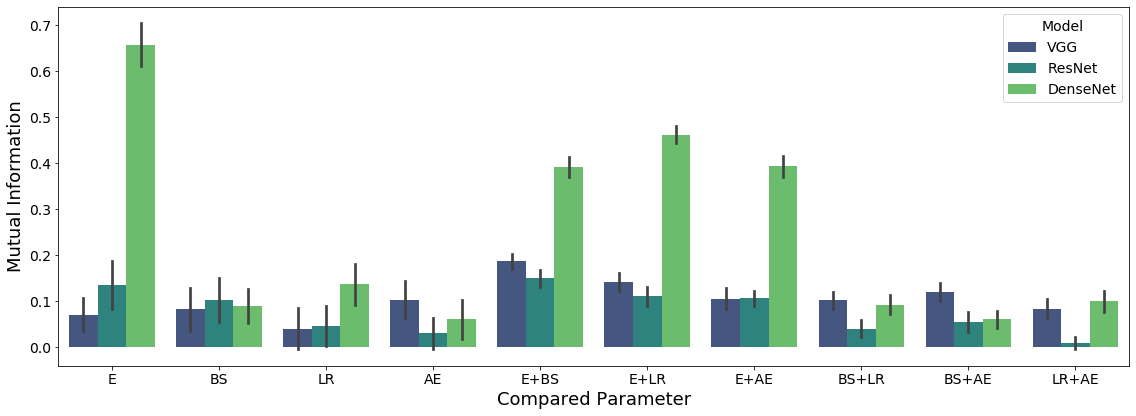

In [264]:
ax = sns.barplot(x="Compared Parameter", y="MI", hue="Model", data=mi_df, palette="viridis", ci="sd")
plt.ylabel("Mutual Information")
fig = plt.gcf()
fig.set_size_inches(16, 6)
plt.tight_layout()
plt.savefig('uni_and_bivariate_mi_ave_perm_normalized_and_digitize_hyperparameters_and_acc_diff_50trials.png', dpi=200)

In [101]:
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize